In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Caminho para os dados
data_dir = '/content/drive/MyDrive/Colab data'
img_size = 96
batch_size = 32

# Classes do dataset
class_names = ['Culex landing', 'Culex smashed',
               'aegypti landing', 'aegypti smashed',
               'albopictus landing', 'albopictus smashed']


In [14]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'Train'),
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='int',
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'Test'),
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='int',
    shuffle=False
)

print("Classes detectadas:", train_dataset.class_names)


Found 4220 files belonging to 6 classes.
Found 1799 files belonging to 6 classes.
Classes detectadas: ['Culex landing', 'Culex smashed', 'aegypti landing', 'aegypti smashed', 'albopictus landing', 'albopictus smashed']


In [15]:
# Normalização simples para [0, 1]
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

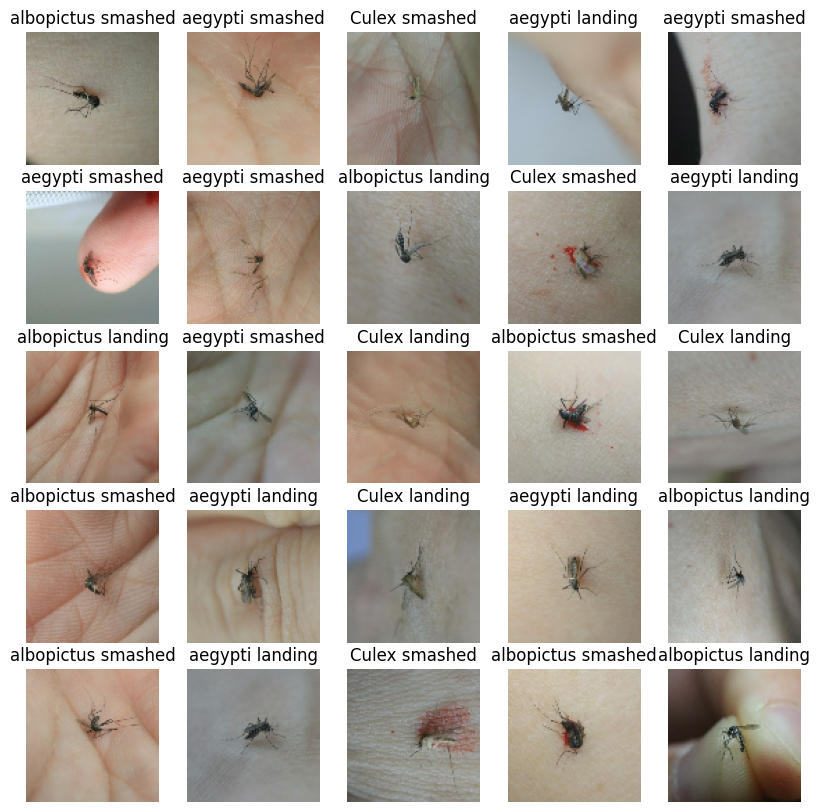

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("float32"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


In [17]:

model = models.Sequential([
    layers.Conv2D(64, (3,3), activation='relu', input_shape=(96, 96, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),  # previne overfitting
    layers.Dense(6)       # 6 classes
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=10)


Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.2123 - loss: 1.7897 - val_accuracy: 0.4452 - val_loss: 1.3366
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.4543 - loss: 1.2931 - val_accuracy: 0.4919 - val_loss: 1.2384
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.5718 - loss: 1.0750 - val_accuracy: 0.5620 - val_loss: 1.0416
Epoch 4/10
 75/132 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.6043 - loss: 0.9904

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(loc='lower right')
plt.title("Acurácia durante o Treinamento")
plt.show()


In [ ]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Matriz de Confusão:\n", conf_matrix)


In [ ]:
for images, labels in test_dataset.take(1):
    img = images[0]
    label = labels[0].numpy()

    plt.imshow(img.numpy().astype("float32"))
    plt.axis('off')
    plt.title(f"Verdadeiro: {class_names[label]}")
    plt.show()

    img_batch = tf.expand_dims(img, 0)
    prediction = model.predict(img_batch)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = tf.nn.softmax(prediction[0])[np.argmax(prediction)].numpy()

    print(f"Classe prevista: {predicted_class} (confiança: {confidence:.2f})")


In [ ]:
import numpy as np
from tqdm import tqdm

num_tests = 100  # número de amostras a avaliar (ajuste se quiser mais)
correct = 0
total_confidence = 0.0
samples_checked = 0

# Iterar sobre o dataset em batches
for images, labels in test_dataset:
    for i in range(len(images)):
        if samples_checked >= num_tests:
            break

        img = tf.expand_dims(images[i], axis=0)
        label = labels[i].numpy()

        prediction = model.predict(img, verbose=0)
        predicted_label = np.argmax(prediction)
        confidence = tf.nn.softmax(prediction[0])[predicted_label].numpy()

        total_confidence += confidence
        if predicted_label == label:
            correct += 1

        samples_checked += 1

    if samples_checked >= num_tests:
        break

# Cálculos finais
accuracy = correct / num_tests * 100
avg_confidence = total_confidence / num_tests * 100

print(f"\n Total de imagens avaliadas: {num_tests}")
print(f" Acertos: {correct}")
print(f" Erros: {num_tests - correct}")
print(f" Acurácia no lote: {accuracy:.2f}%")
print(f" Média de confiança das predições: {avg_confidence:.2f}%")
